In [1]:
import sys

sys.path.append('../src')
from deepymod_torch.DeepMod import iterate_2nd_decay_constant

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
'''
tau_2_values = [0.01]
while tau_2_values[-1] < 1000:
    tau_2_values += [tau_2_values[-1]*2]
'''
tau_2_values = [1]

tau_2_values

[1]

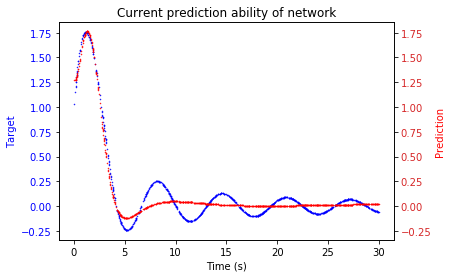

Epoch | Total loss | MSE | PI | L1 
600 1.0E-02 8.2E-03 2.0E-03 6.3E-06
tensor([[0.8312],
        [0.8164],
        [0.3824],
        [0.6323],
        [0.4635],
        [0.7756],
        [0.9084]], requires_grad=True)
lrs are 0.001 0.001
Time elapsed: 11.0 minutes 54.032888412475586 seconds


In [ ]:
iterate_2nd_decay_constant(tau_2_values)